In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
import string
from bs4 import BeautifulSoup
from contractions import fix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Path to your JSON file
file_path = 'News_Category_Dataset_v3.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Drop the specified columns from the DataFrame
df = df.drop(columns=['link', 'authors', 'category'])

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where 'date' couldn't be parsed
df = df.dropna(subset=['date'])

# Download NLTK stopwords
nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to C:\Users\Blu-
[nltk_data]     Ray\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra white space
    text = text.strip()
    
    # Remove stop words
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    
    # Apply stemming
    stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]
    text = ' '.join(stemmed_words)
    
    return text

# Apply text preprocessing to "headline" and "short_description" columns
df['headline'] = df['headline'].apply(preprocess_text)
df['short_description'] = df['short_description'].apply(preprocess_text)


C:\Users\Blu-Ray\AppData\Local\Temp\ipykernel_1076\1748610668.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
C:\Users\Blu-Ray\AppData\Local\Temp\ipykernel_1076\1748610668.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [6]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

# Load BERT model and tokenizer
custom_objects = {'TFBertModel': TFBertModel}
model = tf.keras.models.load_model('my_model02.h5', custom_objects=custom_objects)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_pad(texts, tokenizer, max_length=40):
    inputs = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')
    return inputs['input_ids'], inputs['attention_mask']

# Prepare the data
short_description_ids, short_description_mask = tokenize_and_pad(df['short_description'].tolist(), tokenizer)
headline_ids, headline_mask = tokenize_and_pad(df['headline'].tolist(), tokenizer)

# Combine inputs if needed
inputs = {
    'input_ids': short_description_ids,
    'attention_mask': short_description_mask
}

D:\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
import numpy as np

# Predict sentiments
predictions = model.predict([inputs['input_ids'], inputs['attention_mask']])

# Convert predictions to labels
labels = ['negative', 'positive', 'neutral']
predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

# Add predictions to the DataFrame
df['sentiment'] = predicted_labels

# Count sentiment occurrences
sentiment_counts = df['sentiment'].value_counts()



6548/6548 [==============================] - 6241s 952ms/step


In [14]:
# Print the relevant columns
df[['short_description','headline','sentiment','date']].head(50)

,short_description,headline,sentiment,date
0,health expert said earli predict whether deman...,4 million american roll sleev omicron target c...,negative,2022-09-23
1,subdu passeng crew fled back aircraft confront...,american airlin flyer charg ban life punch fli...,neutral,2022-09-23
2,dog understand could eaten,23 funniest tweet cat dog week sept 17 23,positive,2022-09-23
3,accident put grown toothpast toddler toothbrus...,funniest tweet parent week sept 17 23,negative,2022-09-23
4,ami cooper accus invest firm franklin templeto...,woman call cop black bird watcher lose lawsuit...,neutral,2022-09-22
5,63 year old woman seen work south carolina sto...,cleaner dead belk bathroom 4 day bodi found polic,negative,2022-09-22
6,behind anchor new york pix11 ask journalist mi...,report get ador surpris boyfriend live tv,positive,2022-09-22
7,half million peopl remain without water servic...,puerto rican desper water hurrican fiona rampag,positive,2022-09-22
8,mija director isabel castro combin music docum...,new documentari captur complex child immigr,neutral,2022-09-22
9,white hous offici say crux presid visit u n ye...,biden un call russian war affront bodi charter,neutral,2022-09-21


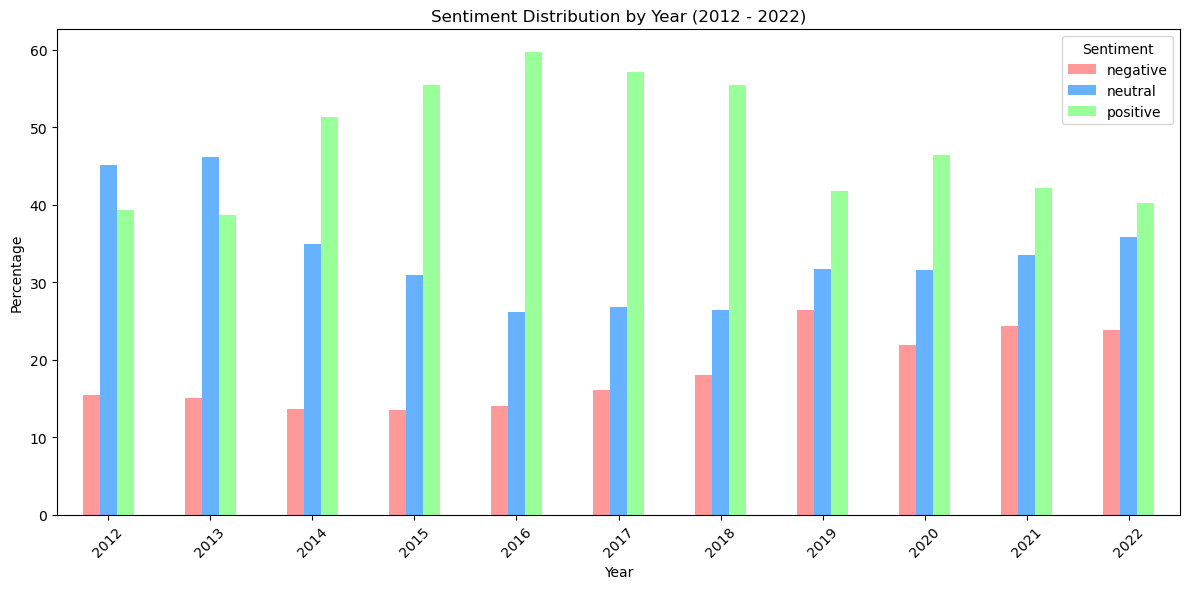

In [15]:
import matplotlib.pyplot as plt

# Define the years for the analysis
years = range(2012, 2023)

# Initialize a dictionary to store sentiment distributions for each year
sentiment_distributions = {year: None for year in years}

# Calculate sentiment distribution for each year
for year in years:
    # Filter data for the specific year
    df_year = df[df['date'].dt.year == year]
    
    # Calculate sentiment distribution
    sentiment_counts = df_year['sentiment'].value_counts(normalize=True) * 100  # Get percentages
    
    sentiment_distributions[year] = sentiment_counts

# Create a DataFrame from the sentiment distributions
sentiment_df = pd.DataFrame(sentiment_distributions).T.fillna(0)  # Fill NaN with 0

# Plotting
sentiment_df.plot(kind='bar', figsize=(12, 6), color=['#FF9999', '#66B2FF', '#99FF99'])
plt.title('Sentiment Distribution by Year (2012 - 2022)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


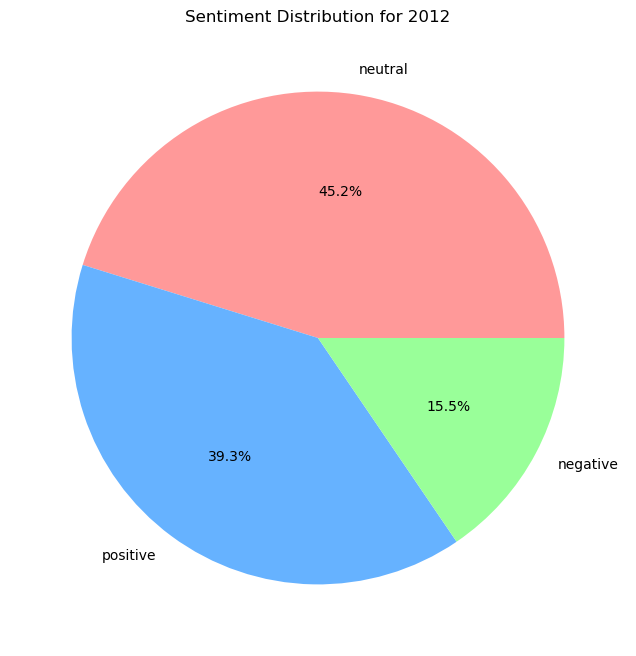

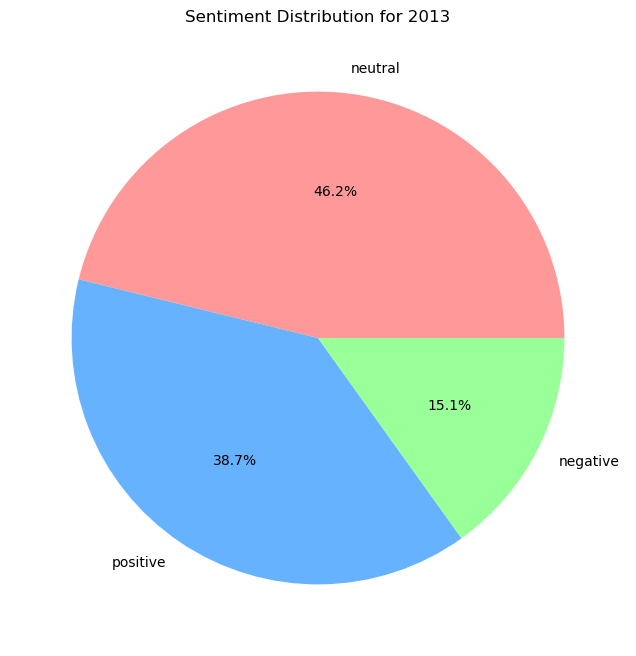

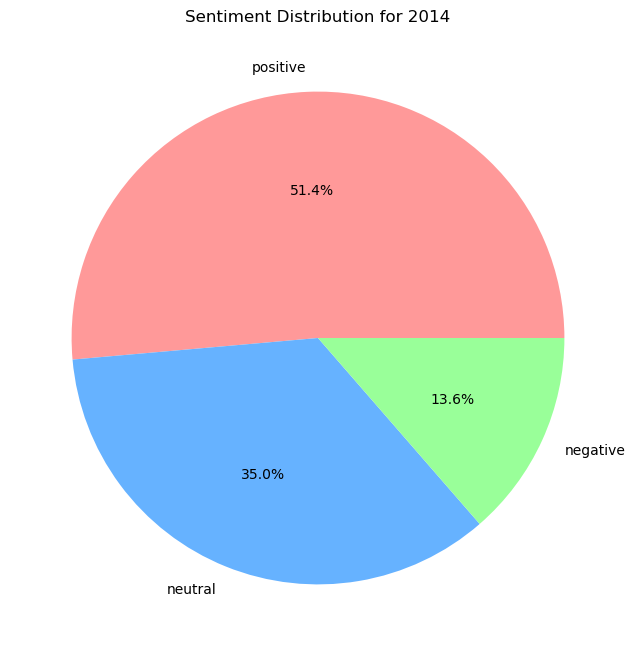

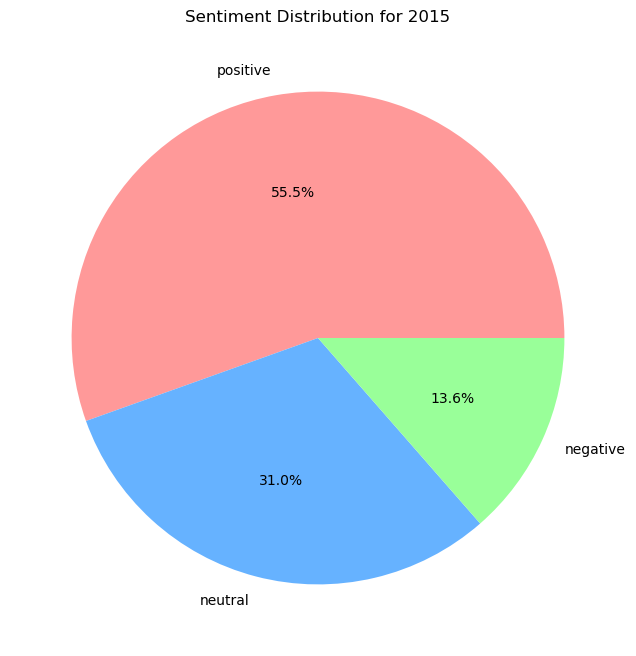

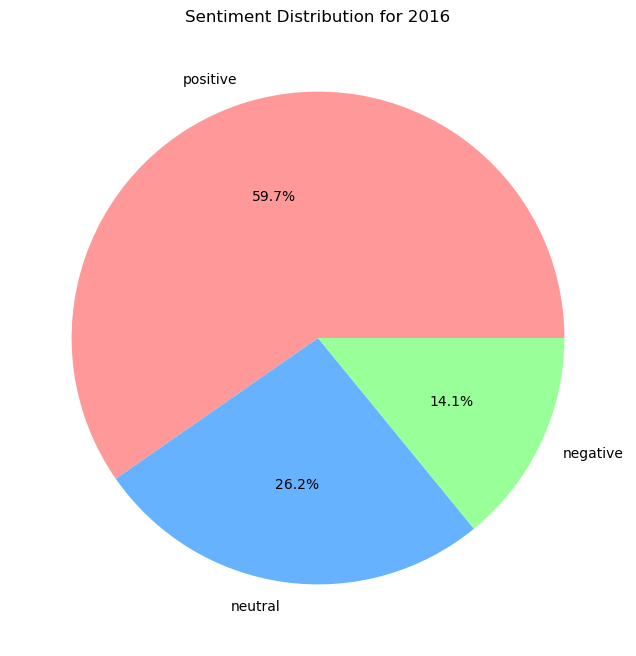

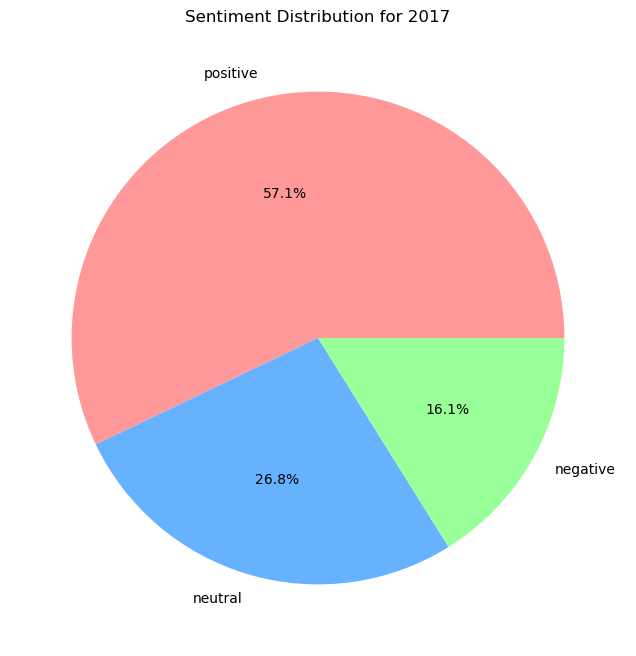

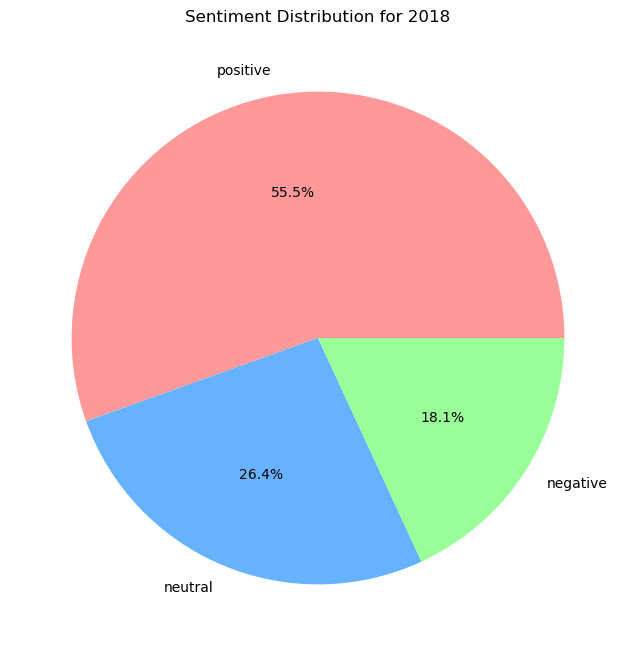

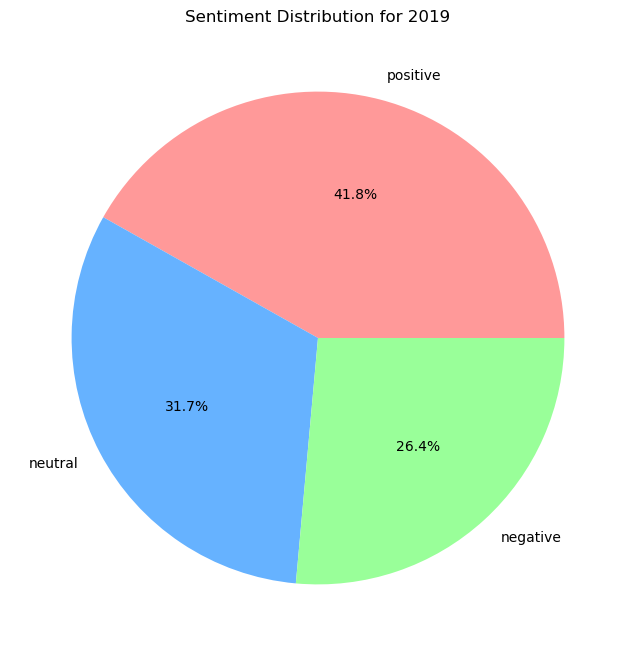

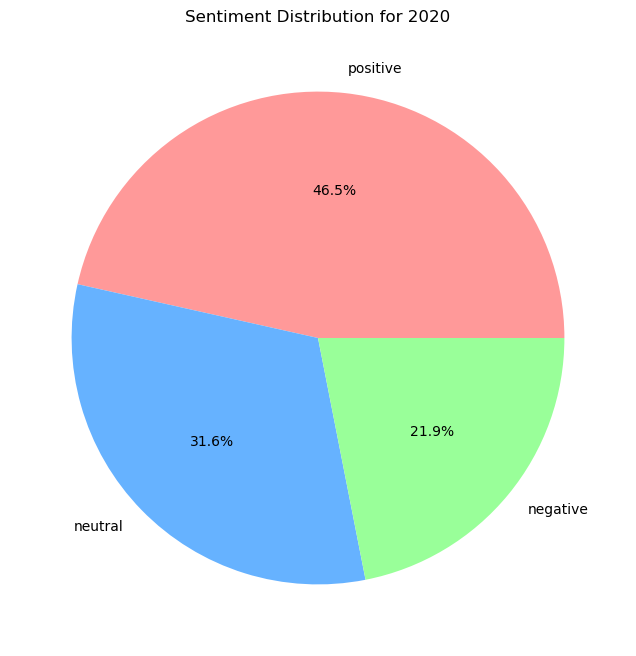

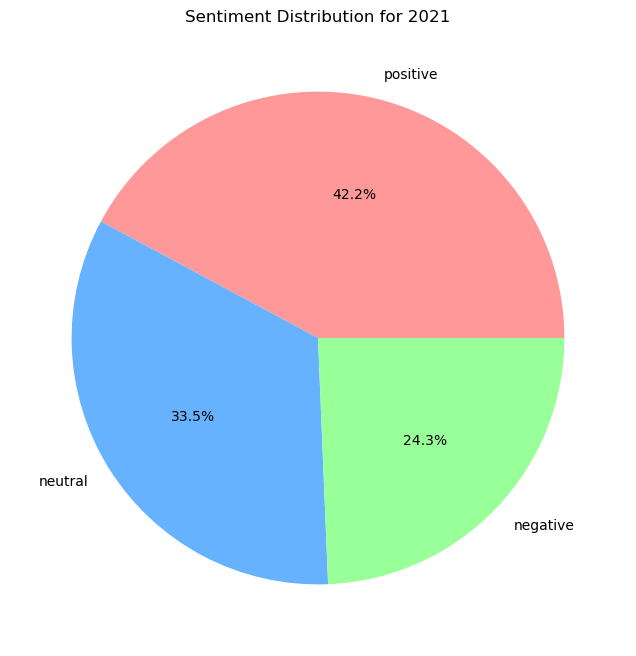

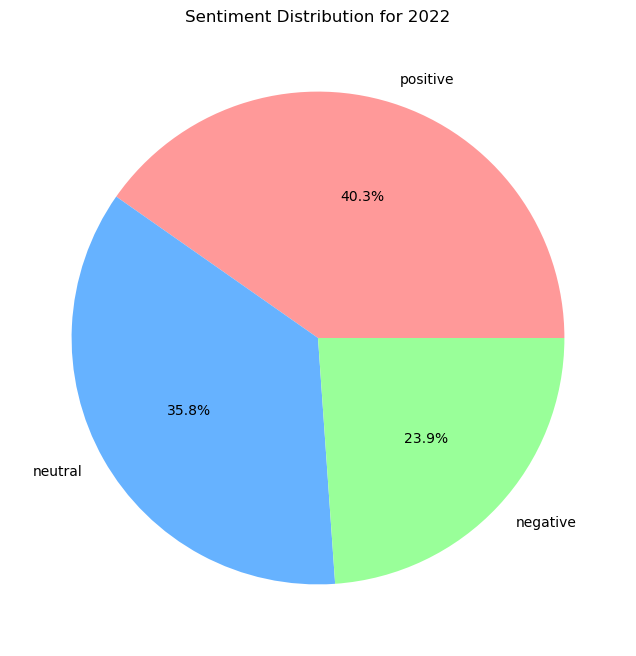

In [16]:
import matplotlib.pyplot as plt

# Define the years for the analysis
years = range(2012, 2023)

# Plot pie charts for each year
for year in years:
    # Filter data for the specific year
    df_year = df[df['date'].dt.year == year]
    
    # Calculate sentiment distribution
    sentiment_counts = df_year['sentiment'].value_counts()
    
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#FF9999', '#66B2FF', '#99FF99'])
    plt.title(f'Sentiment Distribution for {year}')
    plt.show()
